# An√°lise Espectrosc√≥pica Robusta

Este notebook segue as melhores pr√°ticas da literatura para an√°lise espectrosc√≥pica robusta, incluindo:
- Divis√£o dos dados por Kennard-Stone (70-30)
- Remo√ß√£o de outliers espectrais (PCA, T¬≤/Q)
- Remo√ß√£o de outliers dos atributos (boxplot + seaborn)
- Teste de todos os filtros (dependentes e independentes de y)
- Modelagem com PLSR, PCR, RFR, SVMR (hiperpar√¢metros da literatura)

## 1. Imports

In [2]:
# Imports necess√°rios
import os
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import joblib
from sklearn.metrics import r2_score, mean_squared_error
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter, detrend
import warnings
from sklearn.pipeline import Pipeline
import time
from sklearn.model_selection import cross_val_predict

# Cria diret√≥rios para organizar todas as imagens salvas
print("Criando diret√≥rios para salvar os gr√°ficos...")
os.makedirs('graficos_outliers_pca', exist_ok=True)
os.makedirs('graficos_outliers_boxplot', exist_ok=True)
os.makedirs('modelos_salvos', exist_ok=True)
# A pasta para os modelos ser√° criada depois, mas podemos garantir aqui
# Nome da pasta para o notebook geral
os.makedirs('graficos_modelos', exist_ok=True) 
# Nome da pasta para o notebook MLPR
os.makedirs('graficos_mlpr', exist_ok=True) 

warnings.filterwarnings('ignore')

# Configura√ß√µes de plot
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

Criando diret√≥rios para salvar os gr√°ficos...


## 2. Carregamento dos Dados

O primeiro passo em qualquer projeto de ci√™ncia de dados √© carregar e entender os dados. Nesta se√ß√£o, realizamos as seguintes a√ß√µes:
- **Carregamento:** Utilizamos a biblioteca `pandas` para ler o arquivo `dataset_cotton_fruit.xlsx`, que cont√©m os dados espectrais e os valores de refer√™ncia (atributos f√≠sico-qu√≠micos).
- **Separa√ß√£o de Dados:** A fun√ß√£o `load_data` inteligentemente separa o arquivo em duas partes:
    - `metadata`: Um DataFrame contendo as informa√ß√µes de refer√™ncia (ex: SST, PH, Firmeza), que ser√£o nossas vari√°veis-alvo (y).
    - `wavelengths`: Um DataFrame contendo a resposta espectral (absorb√¢ncia ou reflect√¢ncia) em cada comprimento de onda, que ser√£o nossas vari√°veis preditoras (X).
- **Defini√ß√£o de Vari√°veis:** Convertemos os dados espectrais para um array NumPy (`X`) para otimizar os c√°lculos e definimos a lista de `atributos` que desejamos modelar.

In [3]:
# Fun√ß√£o para carregar dados
def load_data(filepath):
    """Carrega dados espectrais e separa metadados de espectros."""
    df = pd.read_excel(filepath, engine='openpyxl')
    
    # Identificar colunas que s√£o comprimentos de onda (num√©ricas)
    numeric_cols = []
    for col in df.columns:
        try:
            float(col)
            numeric_cols.append(col)
        except ValueError:
            continue
    
    # Separar metadados e comprimentos de onda
    metadata = df.drop(columns=numeric_cols)
    wavelengths = df[numeric_cols]
    
    return metadata, wavelengths

# Carregar dados
filepath = 'Data/Original/dataset_cotton_fruit.xlsx'
metadata, wavelengths = load_data(filepath)
X = wavelengths.values
wavelength_values = wavelengths.columns.astype(float)
atributos = ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']

print(f'Dados carregados: {X.shape[0]} amostras, {X.shape[1]} comprimentos de onda')
print(f'Faixa espectral: {wavelength_values.min():.1f} - {wavelength_values.max():.1f} nm')
print(f'Atributos dispon√≠veis: {list(metadata.columns)}')
print(f'Atributos a analisar: {atributos}')

Dados carregados: 250 amostras, 2151 comprimentos de onda
Faixa espectral: 350.0 - 2500.0 nm
Atributos dispon√≠veis: ['Wavelength', 'SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBU (%)', 'UBS (%)']
Atributos a analisar: ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']


## 3. Divis√£o dos Dados com Kennard-Stone (70-30)

Para construir um modelo robusto, √© crucial dividir os dados em conjuntos de calibra√ß√£o (treino) e valida√ß√£o (teste). Em vez de uma divis√£o aleat√≥ria, usamos o algoritmo **Kennard-Stone (KS)**, que √© o padr√£o-ouro para dados espectrais.
- **Por que Kennard-Stone?** O KS seleciona as amostras para o conjunto de calibra√ß√£o de forma a abranger a m√°xima variabilidade espectral poss√≠vel. Ele escolhe as amostras mais diferentes entre si, garantindo que o modelo seja treinado com toda a "diversidade" de espectros presente nos dados.
- **Implementa√ß√£o:**
    - O processo √© repetido para cada atributo (`AT`, `PH`, etc.), pois amostras com valores ausentes (`NaN`) s√£o removidas, resultando em conjuntos ligeiramente diferentes para cada modelo.
    - Os dados s√£o padronizados (`StandardScaler`) antes de aplicar o KS para que a dist√¢ncia euclidiana n√£o seja dominada por vari√°veis de maior escala.
    - Guardamos os √≠ndices originais de cada amostra para rastreamento futuro.

In [4]:
def kennard_stone(X, train_size=0.7):
    """Implementa o algoritmo Kennard-Stone para divis√£o de dados."""
    n_samples = X.shape[0]
    n_train = int(n_samples * train_size)
    
    if n_train < 2:
        raise ValueError("O conjunto de treinamento precisa ter pelo menos duas amostras!")
    
    distances = cdist(X, X, metric='euclidean')
    
    mean_sample = np.mean(X, axis=0)
    first_sample = np.argmax(np.linalg.norm(X - mean_sample, axis=1))
    selected = [first_sample]
    
    remaining = list(range(n_samples))
    remaining.remove(first_sample)
    
    for _ in range(1, n_train):
        dist_to_selected = distances[selected, :]
        min_dist_to_selected = np.min(dist_to_selected[:, remaining], axis=0)
        
        next_sample_idx_in_remaining = np.argmax(min_dist_to_selected)
        next_sample = remaining.pop(next_sample_idx_in_remaining)
        
        selected.append(next_sample)
        
    return np.array(selected), np.array(remaining)

# Divis√£o para cada atributo
dados_divididos = {}

for atributo in atributos:
    y = metadata[atributo].values
    original_indices = np.arange(len(y)) # Guarda os √≠ndices originais
    
    mask = ~np.isnan(y)
    X_clean = X[mask]
    y_clean = y[mask]
    original_indices_clean = original_indices[mask] # Filtra os √≠ndices tamb√©m
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    idx_cal_split, idx_val_split = kennard_stone(X_scaled, train_size=0.7)
    
    X_cal, X_val = X_clean[idx_cal_split], X_clean[idx_val_split]
    y_cal, y_val = y_clean[idx_cal_split], y_clean[idx_val_split]
    
    # Guarda os √≠ndices originais de cada conjunto
    indices_orig_cal = original_indices_clean[idx_cal_split]
    indices_orig_val = original_indices_clean[idx_val_split]
    
    dados_divididos[atributo] = {
        'X_cal': X_cal, 'X_val': X_val,
        'y_cal': y_cal, 'y_val': y_val,
        'indices_orig_cal': indices_orig_cal,
        'indices_orig_val': indices_orig_val
    }
    
    print(f'{atributo}: {X_cal.shape[0]} calibra√ß√£o, {X_val.shape[0]} valida√ß√£o')

print(f'\nDivis√£o Kennard-Stone conclu√≠da para {len(atributos)} atributos!')

AT: 175 calibra√ß√£o, 75 valida√ß√£o
FIRMEZA (N): 175 calibra√ß√£o, 75 valida√ß√£o
PH: 175 calibra√ß√£o, 75 valida√ß√£o
SST: 175 calibra√ß√£o, 75 valida√ß√£o
UBS (%): 175 calibra√ß√£o, 75 valida√ß√£o

Divis√£o Kennard-Stone conclu√≠da para 5 atributos!


## 4. Remo√ß√£o de Outliers Espectrais (PCA, T¬≤/Q) nos Dados de Calibra√ß√£o

Outliers espectrais s√£o amostras cujo espectro √© muito diferente do resto da popula√ß√£o, podendo ser causados por erros de medi√ß√£o, contamina√ß√£o ou caracter√≠sticas √∫nicas da amostra. Eles podem prejudicar significativamente a capacidade de generaliza√ß√£o do modelo.
- **M√©todo PCA (T¬≤/Q):** Usamos a An√°lise de Componentes Principais (PCA) para identificar esses outliers.
    - **Estat√≠stica T¬≤ (Hotelling's T¬≤):** Mede a varia√ß√£o de uma amostra *dentro* do modelo PCA. Valores altos indicam que a amostra √© um outlier na combina√ß√£o das vari√°veis principais.
    - **Estat√≠stica Q (Res√≠duos):** Mede a varia√ß√£o da amostra *fora* do modelo PCA (o que o modelo n√£o conseguiu capturar). Valores altos indicam que a estrutura do espectro da amostra √© anormal.
- **L√≥gica:** Uma amostra √© considerada outlier se seu valor de T¬≤ ou Q ultrapassa um limite de confian√ßa (geralmente 3 desvios padr√£o da m√©dia).
- **Importante:** A remo√ß√£o de outliers √© feita **apenas no conjunto de calibra√ß√£o**. O conjunto de valida√ß√£o deve permanecer intacto para simular dados "reais" que o modelo encontrar√° no futuro.

In [5]:
def pca_outlier_removal(X, n_components=10, threshold=3):
    """Remove outliers usando PCA com estat√≠sticas T¬≤ e Q."""
    # Padronizar dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calcular estat√≠stica T¬≤ (Hotelling's T¬≤)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0)) ** 2, axis=1)
    
    # Calcular estat√≠stica Q (res√≠duos)
    X_reconstructed = pca.inverse_transform(X_pca)
    Q = np.sum((X_scaled - X_reconstructed) ** 2, axis=1)
    
    # Definir limites (m√©dia + threshold * desvio padr√£o)
    T2_limit = np.mean(T2) + threshold * np.std(T2)
    Q_limit = np.mean(Q) + threshold * np.std(Q)
    
    # Identificar outliers
    outliers_mask = (T2 > T2_limit) | (Q > Q_limit)
    
    # Retornamos a m√°scara de quem N√ÉO √© outlier e o modelo PCA treinado
    return ~outliers_mask, pca, T2, Q, T2_limit, Q_limit

# Remover outliers espectrais dos dados de calibra√ß√£o
dados_pca = {}

for atributo in atributos:
    X_cal = dados_divididos[atributo]['X_cal']
    y_cal = dados_divididos[atributo]['y_cal']
    indices_orig_cal = dados_divididos[atributo]['indices_orig_cal']
    
    # Chama a fun√ß√£o de remo√ß√£o de outliers e armazena todos os resultados
    keep_mask, pca_model, T2, Q, T2_limit, Q_limit = pca_outlier_removal(X_cal)
    
    # Identifica e informa os outliers removidos
    outliers_indices = indices_orig_cal[~keep_mask]
    print(f'{atributo}: {len(outliers_indices)} outliers espectrais removidos da calibra√ß√£o.')
    if len(outliers_indices) > 0:
        print(f'  √çndices Originais Removidos: {outliers_indices}')
    
    # Filtra os dados de calibra√ß√£o
    X_cal_clean = X_cal[keep_mask]
    y_cal_clean = y_cal[keep_mask]
    indices_orig_cal_clean = indices_orig_cal[keep_mask]
    
    dados_pca[atributo] = {
        'X_cal': X_cal_clean,
        'y_cal': y_cal_clean,
        'indices_orig_cal': indices_orig_cal_clean,
        'pca_model': pca_model,
        'T2': T2,
        'Q': Q,
        'T2_limit': T2_limit,
        'Q_limit': Q_limit,
        'keep_mask': keep_mask
    }
    
    print(f'  Calibra√ß√£o: {X_cal_clean.shape[0]} amostras')
    print(f'  Valida√ß√£o: {dados_divididos[atributo]["X_val"].shape[0]} amostras')
    print()


AT: 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras

FIRMEZA (N): 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras

PH: 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras

SST: 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras

UBS (%): 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras



### 4.1 Verifica√ß√£o de Outliers Espectrais no Conjunto de Valida√ß√£o

Ap√≥s construir o modelo de PCA com os dados de calibra√ß√£o limpos, podemos us√°-lo para avaliar o conjunto de valida√ß√£o. O objetivo aqui **n√£o √© remover** amostras da valida√ß√£o, mas sim entender se ele cont√©m amostras que seriam consideradas "estranhas" pelo modelo.
- **Metodologia:**
    1. Padronizamos os dados de valida√ß√£o usando o `scaler` treinado na calibra√ß√£o.
    2. Projetamos esses dados no espa√ßo PCA do modelo de calibra√ß√£o.
    3. Calculamos as estat√≠sticas T¬≤ e Q para as amostras de valida√ß√£o.
    4. Comparamos esses valores com os **limites (T¬≤_limit e Q_limit) definidos na calibra√ß√£o**.
- **Interpreta√ß√£o:** Se amostras de valida√ß√£o excederem os limites, isso indica que o modelo pode ter dificuldade em prediz√™-las, pois elas representam uma variabilidade n√£o vista (ou removida) no treino. Isso √© uma informa√ß√£o valiosa sobre a robustez do modelo.

In [6]:
# Verifica√ß√£o de Outliers na Valida√ß√£o
print("--- Verifica√ß√£o de Outliers no Conjunto de Valida√ß√£o ---")
for atributo in atributos:
    # Carrega o modelo PCA e os dados de valida√ß√£o
    pca_model = dados_pca[atributo]['pca_model']
    X_val = dados_divididos[atributo]['X_val']
    indices_orig_val = dados_divididos[atributo]['indices_orig_val']
    
    # Recalcula os limites usando o modelo salvo, se necess√°rio
    # (Ou usa os limites j√° calculados e salvos anteriormente)
    
    # Padroniza e projeta os dados de valida√ß√£o
    scaler_val = StandardScaler().fit(dados_divididos[atributo]['X_cal']) # Usa o scaler da calibra√ß√£o
    X_val_scaled = scaler_val.transform(X_val)
    X_val_pca = pca_model.transform(X_val_scaled)

    # Calcula T¬≤ e Q para a valida√ß√£o
    T2_val = np.sum((X_val_pca / np.std(X_val_pca, axis=0)) ** 2, axis=1)
    X_val_reconstructed = pca_model.inverse_transform(X_val_pca)
    Q_val = np.sum((X_val_scaled - X_val_reconstructed) ** 2, axis=1)

    # Identifica outliers da valida√ß√£o usando os limites da CALIBRA√á√ÉO
    outliers_val_mask = (T2_val > T2_limit) | (Q_val > Q_limit)
    outliers_val_indices = indices_orig_val[outliers_val_mask]
    
    print(f'\nAtributo: {atributo}')
    if len(outliers_val_indices) > 0:
        print(f'  {len(outliers_val_indices)} amostras de VALIDA√á√ÉO excedem os limites da calibra√ß√£o.')
        print(f'  √çndices Originais: {outliers_val_indices}')
    else:
        print('  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.')

--- Verifica√ß√£o de Outliers no Conjunto de Valida√ß√£o ---

Atributo: AT
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.

Atributo: FIRMEZA (N)
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.

Atributo: PH
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.

Atributo: SST
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.

Atributo: UBS (%)
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.


### 4.2 Gr√°ficos de Outliers T¬≤ e Q

In [7]:
for atributo in atributos:
    d = dados_pca[atributo][0]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gr√°fico 1: Vari√¢ncia explicada cumulativa
    # Acessa o modelo PCA com a chave correta 'pca_model'
    cumulative_variance = np.cumsum(d['pca_model'].explained_variance_ratio_)
    axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', linewidth=2, markersize=6)
    axes[0].set_xlabel('N√∫mero de Componentes Principais')
    axes[0].set_ylabel('Vari√¢ncia Explicada Cumulativa')
    axes[0].set_title(f'Vari√¢ncia Explicada - {atributo}')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    axes[0].legend()
    
    # Gr√°fico 2: T¬≤ vs Q (detec√ß√£o de outliers)
    # Acessa as vari√°veis T2, Q, T2_limit, Q_limit e keep_mask com as chaves corretas
    scatter = axes[1].scatter(d['T2'], d['Q'], c=d['keep_mask'], cmap='coolwarm', 
                              edgecolor='k', alpha=0.7, s=50)
    axes[1].axhline(d['Q_limit'], color='r', linestyle='--', linewidth=2, label=f'Q Limit: {d["Q_limit"]:.2f}')
    axes[1].axvline(d['T2_limit'], color='g', linestyle='--', linewidth=2, label=f'T¬≤ Limit: {d["T2_limit"]:.2f}')
    axes[1].set_xlabel("Hotelling's T¬≤")
    axes[1].set_ylabel('Q Residual')
    axes[1].set_title(f'Detec√ß√£o de Outliers - {atributo}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Adicionar legenda de cores (esta parte tamb√©m foi ajustada para a chave 'keep_mask')
    legend1 = axes[1].legend(*scatter.legend_elements(), title="Status")
    axes[1].add_artist(legend1)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Gr√°ficos de outliers para {atributo} exibidos.')
    print()

KeyError: 0

## 5. Remo√ß√£o de Outliers dos Atributos (Boxplot + Seaborn)

Al√©m dos outliers espectrais (em X), podemos ter outliers nos valores de refer√™ncia (em y). Por exemplo, um valor de pH ou SST que √© analiticamente improv√°vel ou resultado de um erro de anota√ß√£o.
- **M√©todo (IQR):** O m√©todo do Intervalo Interquartil (IQR) √© uma forma estat√≠stica robusta de identificar esses pontos.
    - `IQR = Q3 (percentil 75) - Q1 (percentil 25)`
    - Um valor √© considerado outlier se estiver abaixo de `Q1 - 1.5 * IQR` ou acima de `Q3 + 1.5 * IQR`.
- **Visualiza√ß√£o:** O `boxplot` √© a ferramenta visual perfeita para essa an√°lise, pois ele desenha os "bigodes" exatamente nesses limites de 1.5 * IQR, mostrando os outliers como pontos individuais.
- **A√ß√£o:** Novamente, a remo√ß√£o √© feita apenas no conjunto de calibra√ß√£o.

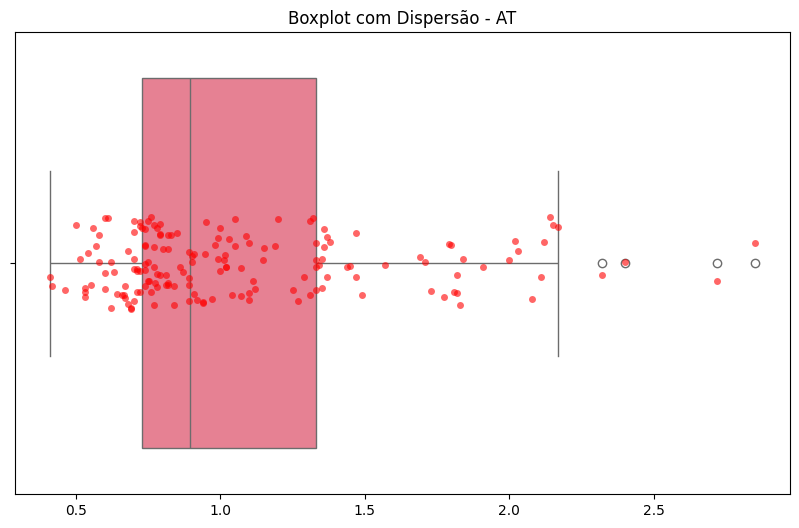

AT: 4 outliers de atributo removidos.
  √çndices Originais Removidos: [15 12 30 19]
  Calibra√ß√£o final: 164 amostras
  Valida√ß√£o: 75 amostras



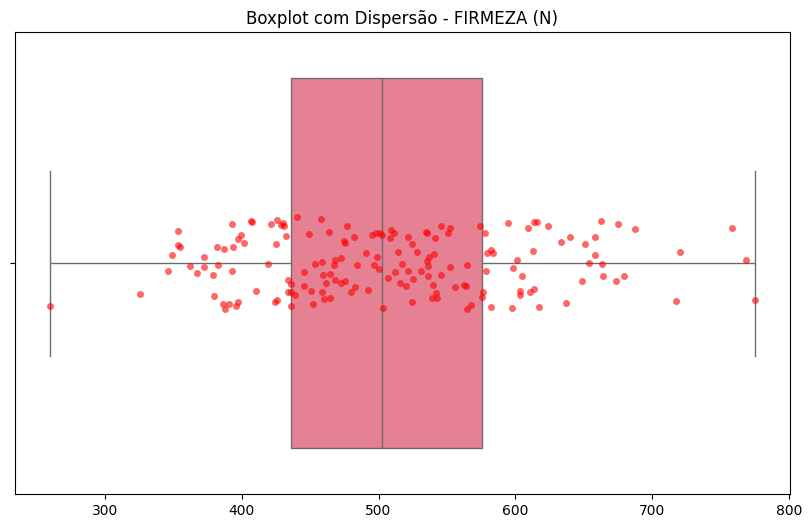

FIRMEZA (N): 0 outliers de atributo removidos.
  Calibra√ß√£o final: 168 amostras
  Valida√ß√£o: 75 amostras



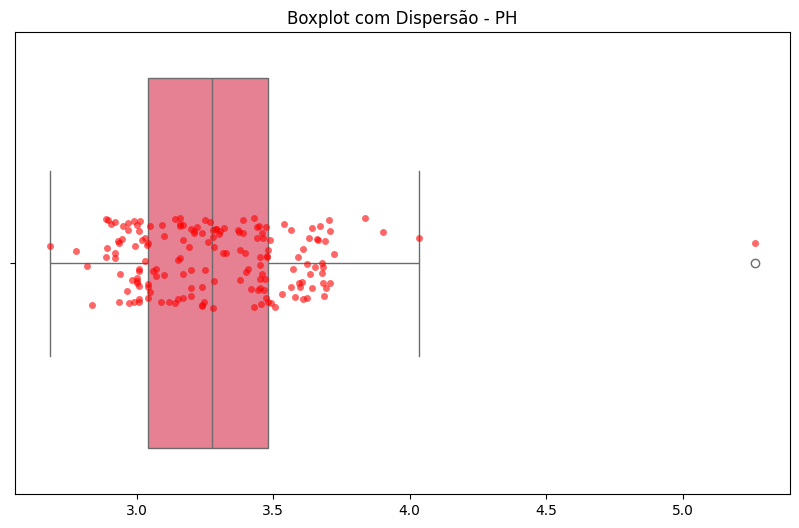

PH: 1 outliers de atributo removidos.
  √çndices Originais Removidos: [56]
  Calibra√ß√£o final: 167 amostras
  Valida√ß√£o: 75 amostras



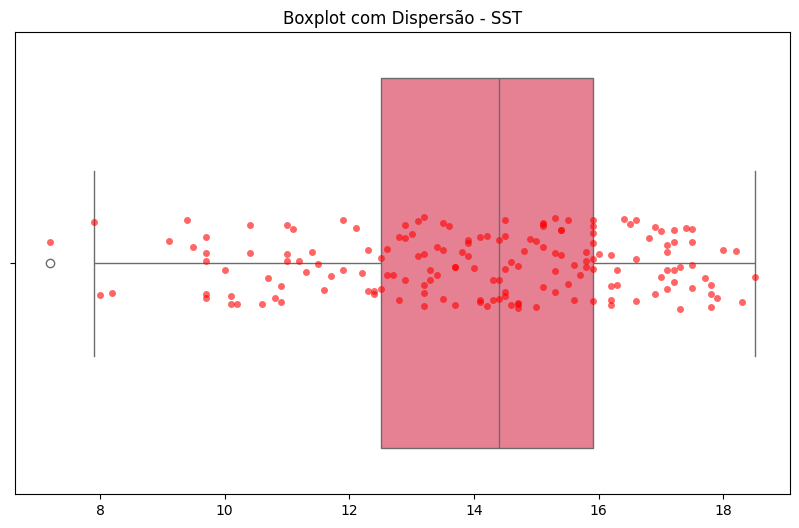

SST: 1 outliers de atributo removidos.
  √çndices Originais Removidos: [30]
  Calibra√ß√£o final: 167 amostras
  Valida√ß√£o: 75 amostras



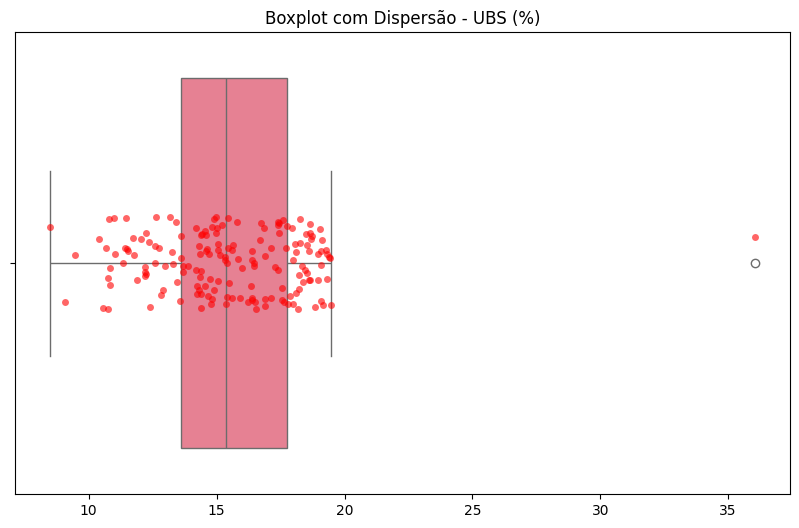

UBS (%): 1 outliers de atributo removidos.
  √çndices Originais Removidos: [242]
  Calibra√ß√£o final: 167 amostras
  Valida√ß√£o: 75 amostras



In [ ]:
# Remover outliers dos atributos usando boxplot e IQR
dados_final = {}

for atributo in atributos:
    # Pega os dados j√° limpos de outliers espectrais
    d = dados_pca[atributo]
    X_cal = d['X_cal']
    y_cal = d['y_cal']
    indices_orig_cal = d['indices_orig_cal']
    
    # Boxplot (seu c√≥digo de plotagem original pode ser mantido aqui)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=y_cal)
    sns.stripplot(x=y_cal, color='red', alpha=0.6)
    plt.title(f'Boxplot com Dispers√£o - {atributo}')
    
    nome_arquivo = f'graficos_outliers_boxplot/boxplot_outliers_{atributo}.png'
    plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
    
    plt.show()

    # L√≥gica de remo√ß√£o de outliers
    Q1 = np.percentile(y_cal, 25)
    Q3 = np.percentile(y_cal, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    keep_mask_attr = (y_cal >= lower_bound) & (y_cal <= upper_bound)
    
    # Identifica e informa os outliers removidos
    outliers_attr_indices = indices_orig_cal[~keep_mask_attr]
    print(f'{atributo}: {len(outliers_attr_indices)} outliers de atributo removidos.')
    if len(outliers_attr_indices) > 0:
        print(f'  √çndices Originais Removidos: {outliers_attr_indices}')
    
    # Armazena os dados finais e limpos para modelagem
    dados_final[atributo] = {
        'X_cal': X_cal[keep_mask_attr],
        'y_cal': y_cal[keep_mask_attr],
        'X_val': dados_divididos[atributo]['X_val'], # Valida√ß√£o original
        'y_val': dados_divididos[atributo]['y_val']   # Valida√ß√£o original
    }
    
    print(f'  Calibra√ß√£o final: {dados_final[atributo]["X_cal"].shape[0]} amostras')
    print(f'  Valida√ß√£o: {dados_final[atributo]["X_val"].shape[0]} amostras')
    print()

## 6. Filtros de Pr√©-processamento (Independentes e Dependentes de y)

Os dados espectrais brutos cont√™m diversas fontes de varia√ß√£o indesejada que podem mascarar a informa√ß√£o qu√≠mica relevante. Essas varia√ß√µes podem ser causadas por espalhamento de luz (efeitos f√≠sicos da amostra), mudan√ßas na linha de base (drift do instrumento) e ru√≠do. O pr√©-processing visa minimizar esses efeitos para que o modelo foque na correla√ß√£o entre o espectro e o atributo de interesse.

Neste notebook, testamos uma ampla gama de filtros, divididos em duas categorias:

### Filtros Independentes de y

S√£o aplicados apenas aos espectros (`X`) e n√£o utilizam a informa√ß√£o da vari√°vel alvo (`y`).

-   **`Raw`**: Utiliza os dados espectrais brutos, sem nenhum tratamento. Serve como uma linha de base para comparar a efic√°cia dos outros filtros.
-   **`MSC` (Multiplicative Scatter Correction)**: Corrige o espalhamento de luz (aditivo e multiplicativo) causado por varia√ß√µes no tamanho de part√≠cula e compacta√ß√£o da amostra. Ele ajusta cada espectro para se parecer mais com um espectro "ideal" (geralmente a m√©dia de todos os espectros).
-   **`SNV` (Standard Normal Variate)**: Alternativa ao MSC que tamb√©m corrige o espalhamento de luz. A diferen√ßa √© que o SNV padroniza cada espectro individualmente (subtrai a m√©dia e divide pelo desvio padr√£o daquele espectro), sem usar um espectro de refer√™ncia.
-   **`SG_D1` e `SG_D2` (Savitzky-Golay Derivatives)**: Calcula a primeira ou a segunda derivada do espectro. Derivadas s√£o excelentes para remover desvios de linha de base (efeitos aditivos) e para resolver picos espectrais sobrepostos, real√ßando a informa√ß√£o de bandas de absor√ß√£o espec√≠ficas.
-   **`Detrend`**: Remove tend√™ncias lineares ou polinomiais da linha de base do espectro. √â muito eficaz para corrigir "inclina√ß√µes" no espectro causadas por drift do instrumento.
-   **`Normalize`**: Realiza uma normaliza√ß√£o Min-Max, escalonando a intensidade de cada espectro para um intervalo fixo (geralmente [0, 1]). Ajuda a corrigir varia√ß√µes de intensidade causadas por diferen√ßas na dist√¢ncia da amostra ou na pot√™ncia da fonte de luz.
-   **`EMSC` (Extended Multiplicative Signal Correction)**: Uma vers√£o avan√ßada do MSC. Al√©m de corrigir os efeitos de espalhamento, o EMSC pode incluir termos polinomiais para modelar e remover efeitos de linha de base mais complexos e n√£o-lineares.
-   **`Continuum Removal`**: T√©cnica que normaliza os espectros para que as bandas de absor√ß√£o possam ser comparadas em termos de sua profundidade, e n√£o de sua intensidade absoluta. Ele ajusta um "envelope" (casco convexo) sobre o espectro e divide o espectro original por este envelope, real√ßando as caracter√≠sticas de absor√ß√£o.
-   **`Wavelet_Denoising`**: Utiliza a Transformada Wavelet para decompor o espectro em diferentes n√≠veis de frequ√™ncia. A t√©cnica permite remover o ru√≠do (geralmente presente em altas frequ√™ncias) de forma muito eficaz, preservando as principais caracter√≠sticas do sinal espectral.

### Filtros Dependentes de y e Combina√ß√µes

Estes filtros utilizam a vari√°vel alvo (`y`) para otimizar a remo√ß√£o de varia√ß√£o n√£o correlacionada em `X`, ou s√£o combina√ß√µes sequenciais de m√∫ltiplos filtros para um tratamento mais completo.

-   **`OSC_1` e `OSC_2` (Orthogonal Signal Correction)**: Filtro que remove componentes (1 ou 2, neste caso) dos espectros `X` que s√£o ortogonais (n√£o correlacionados) √† vari√°vel alvo `y`. O objetivo √© limpar `X` da varia√ß√£o que n√£o ajuda na predi√ß√£o, potencialmente melhorando o modelo subsequente. Esta t√©cnica √© frequentemente referida como um pr√©-processamento **OPLS** (Orthogonal Projections to Latent Structures).
-   **`MSC_SG_OSC`**: Uma **cadeia de pr√©-processamentos** aplicada na seguinte ordem:
    1.  `MSC` para corrigir o espalhamento.
    2.  `Savitzky-Golay (1¬™ derivada)` para corrigir a linha de base.
    3.  `OSC (1 componente)` para remover varia√ß√£o n√£o correlacionada com `y`.
-   **`OPLS1_SNV_SG_D1` e `OPLS2_SNV_SG_D1`**: Outra cadeia de processamento:
    1.  `SNV` para corre√ß√£o de espalhamento.
    2.  `Savitzky-Golay (1¬™ derivada)`.
    3.  `OPLS/OSC` para remover 1 ou 2 componentes ortogonais a `y`.
-   **`SNV_Detrend_SG_D1`**: Uma combina√ß√£o de filtros independentes de `y`, mas que, por sua complexidade, √© testada junto √†s outras cadeias:
    1.  `SNV`.
    2.  `Detrend` para remo√ß√£o de tend√™ncia.
    3.  `Savitzky-Golay (1¬™ derivada)`.

In [ ]:
# Implementa√ß√£o dos filtros de pr√©-processamento
# Filtros independentes de y
def msc(X):
    """Multiplicative Scatter Correction."""
    X = np.asarray(X)
    mean_spectrum = np.mean(X, axis=0)
    corrected_spectra = np.zeros_like(X)
    for i in range(X.shape[0]):
        slope, intercept = np.polyfit(mean_spectrum, X[i, :], 1)
        corrected_spectra[i, :] = (X[i, :] - intercept) / slope
    return corrected_spectra

def snv(X):
    """Standard Normal Variate."""
    X = np.asarray(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

def savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1):
    """Savitzky-Golay filter."""
    return savgol_filter(X, window_length=window_size, polyorder=poly_order, deriv=deriv_order, axis=1)

def detrend_filter(X):
    """Detrending filter."""
    return detrend(X, axis=1)

def normalize(X):
    """Normaliza√ß√£o Min-Max."""
    return (X - np.min(X, axis=1, keepdims=True)) / (np.max(X, axis=1, keepdims=True) - np.min(X, axis=1, keepdims=True))

def emsc(X, reference=None):
    """Extended Multiplicative Signal Correction."""
    X = np.asarray(X)
    if reference is None:
        reference = np.mean(X, axis=0)  # Usa o espectro m√©dio como refer√™ncia
    
    X_corr = np.zeros_like(X)
    for i in range(X.shape[0]):
        # Modelo: X[i] ‚âà a + b*reference
        model = np.vstack([np.ones_like(reference), reference]).T
        params, _, _, _ = np.linalg.lstsq(model, X[i, :], rcond=None)
        a, b = params[0], params[1]
        X_corr[i,:] = (X[i, :] - a) / b
    return X_corr

def continuum_removal(X, wavelengths):
    """Continuum Removal."""
    X = np.asarray(X)
    X_cr = np.zeros_like(X)
    for i in range(X.shape[0]):
        spectrum = X[i, :]
        # Encontra os pontos do casco convexo superior
        q_u = [0]
        for k in range(1, len(wavelengths) - 1):
            s_k = (spectrum[len(wavelengths)-1] - spectrum[0]) / (wavelengths[-1] - wavelengths[0])
            s_q = (spectrum[k] - spectrum[q_u[-1]]) / (wavelengths[k] - wavelengths[q_u[-1]])
            if s_q > s_k:
                q_u.append(k)
        q_u.append(len(wavelengths)-1)
        
        # Interpola√ß√£o linear entre os pontos do casco
        continuum = np.interp(wavelengths, wavelengths[q_u], spectrum[q_u])
        X_cr[i, :] = spectrum / continuum
    return X_cr

def wavelet_denoising(X, wavelet='db4', level=4):
    """Wavelet Transform para Denoising."""
    X = np.asarray(X)
    original_length = X.shape[1]
    denoised_list = []

    for i in range(X.shape[0]):
        # 1. Decomposi√ß√£o Wavelet
        coeffs = pywt.wavedec(X[i, :], wavelet, level=level)

        # 2. C√°lculo do limiar (threshold)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(original_length))

        # 3. Aplica√ß√£o do filtro (soft thresholding) nos coeficientes de detalhe
        coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]

        # 4. Reconstru√ß√£o do sinal
        reconstructed_signal = pywt.waverec(coeffs, wavelet)

        # 5. Ajuste do tamanho
        denoised_list.append(reconstructed_signal[:original_length])

    return np.asarray(denoised_list)

# Filtros dependentes de y (Orthogonal Signal Correction)
class OrthogonalCorrection:
    """Orthogonal Signal Correction (OSC)."""
    def __init__(self, n_components=1):
        self.n_components = n_components
    
    def fit_transform(self, X, y):
        X, y = np.asarray(X), np.asarray(y).ravel()
        self.w_ortho_ = []
        self.p_ortho_ = []
        self.X_corr_ = X.copy()
        
        for _ in range(self.n_components):
            pls = PLSRegression(n_components=1)
            pls.fit(self.X_corr_, y)
            t = pls.x_scores_
            w = pls.x_weights_
            p = pls.x_loadings_
            
            # Componente Ortogonal
            w_ortho = p - (np.dot(w.T, p) / np.dot(w.T, w)) * w
            t_ortho = np.dot(self.X_corr_, w_ortho)
            p_ortho = np.dot(t_ortho.T, self.X_corr_) / np.dot(t_ortho.T, t_ortho)
            
            # Remover varia√ß√£o ortogonal
            self.X_corr_ -= np.dot(t_ortho, p_ortho)
            self.w_ortho_.append(w_ortho)
            self.p_ortho_.append(p_ortho)
        
        return self.X_corr_
    
    def transform(self, X):
        X_res = np.asarray(X).copy()
        for i in range(self.n_components):
            t_ortho = np.dot(X_res, self.w_ortho_[i])
            X_res -= np.dot(t_ortho, self.p_ortho_[i])
        return X_res

# Dicion√°rio de filtros independentes de y
filtros_independentes = {
    'Raw': lambda X: X,
    'MSC': msc,
    'SNV': snv,
    'SG_D1': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1),
    'SG_D2': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=2),
    'Detrend': detrend_filter,
    'Normalize': normalize,
    'EMSC': emsc,
    'Continuum_Removal': lambda X: continuum_removal(X, wavelength_values),
    'Wavelet_Denoising': wavelet_denoising
}

# Dicion√°rio de filtros dependentes de y
filtros_dependentes = {
    'OSC_1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(X, y),
    'OSC_2': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(X, y),
    'MSC_SG_OSC': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(msc(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS1_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS2_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'SNV_Detrend_SG_D1': lambda X, y: savitzky_golay(detrend_filter(snv(X)), window_size=11, poly_order=2, deriv_order=1)
}

print(f'Filtros independentes de y: {list(filtros_independentes.keys())}')
print(f'Filtros dependentes de y: {list(filtros_dependentes.keys())}')
print(f'Total de filtros: {len(filtros_independentes) + len(filtros_dependentes)}')

Filtros independentes de y: ['Raw', 'MSC', 'SNV', 'SG_D1', 'SG_D2', 'Detrend', 'Normalize', 'EMSC', 'Continuum_Removal', 'Wavelet_Denoising']
Filtros dependentes de y: ['OSC_1', 'OSC_2', 'MSC_SG_OSC', 'OPLS1_SNV_SG_D1', 'OPLS2_SNV_SG_D1', 'SNV_Detrend_SG_D1']
Total de filtros: 16


In [ ]:
print("Shape de X:", X.shape)
print("Shape de wavelengths:", wavelengths.shape)

Shape de X: (250, 2151)
Shape de wavelengths: (250, 2151)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_filtros_independentes(X, wavelengths_values, filtros_independentes):
    """
    Plota os gr√°ficos dos filtros independentes aplicados ao dataset, salvando uma imagem separada para cada filtro.

    Par√¢metros:
    - X: np.ndarray, dados espectrais originais (amostras x comprimentos de onda).
    - wavelengths_values: np.ndarray, valores dos comprimentos de onda.
    - filtros_independentes: dict, dicion√°rio de fun√ß√µes de filtros independentes.

    Retorno:
    - Salva uma imagem para cada filtro aplicado.
    """
    for nome_filtro, func_filtro in filtros_independentes.items():
        # Aplica o filtro
        X_filtrado = func_filtro(X)

        # Cria a figura para o filtro atual
        plt.figure(figsize=(10, 6))
        for espectro in X_filtrado:
            plt.plot(wavelengths_values, espectro, alpha=0.7)
        plt.title(f"Filtro: {nome_filtro}", fontsize=14)
        plt.xlabel("Comprimento de Onda (nm)", fontsize=12)
        plt.ylabel("Intensidade", fontsize=12)
        plt.grid(True)

        # Salva a figura
        plt.savefig(f"grafico_{nome_filtro}.png")
        plt.close()

In [ ]:
# Depura√ß√£o dos dados de entrada
print("Formato de X:", X.shape)
print("Primeiros valores de X:", X[:5])
print("Formato de wavelengths_values:", wavelength_values.shape)
print("Primeiros valores de wavelengths_values:", wavelength_values[:5])
print("Chaves de filtros_independentes:", list(filtros_independentes.keys()))

Formato de X: (250, 2151)
Primeiros valores de X: [[0.12147462 0.1339322  0.12126856 ... 0.01877304 0.0187442  0.0175124 ]
 [0.22830937 0.22503523 0.23509654 ... 0.0261977  0.02666582 0.02573513]
 [0.16015423 0.15416337 0.15199672 ... 0.01907885 0.02003937 0.02314041]
 [0.11125468 0.1129544  0.11684808 ... 0.01258329 0.01229228 0.01341544]
 [0.17437007 0.16852736 0.14880459 ... 0.01777379 0.0179632  0.01829009]]
Formato de wavelengths_values: (2151,)
Primeiros valores de wavelengths_values: Index([350.0, 351.0, 352.0, 353.0, 354.0], dtype='float64')
Chaves de filtros_independentes: ['Raw', 'MSC', 'SNV', 'SG_D1', 'SG_D2', 'Detrend', 'Normalize', 'EMSC', 'Continuum_Removal', 'Wavelet_Denoising']


In [ ]:
# Teste individual dos filtros
for nome_filtro, func_filtro in filtros_independentes.items():
    try:
        print(f"Testando filtro: {nome_filtro}")
        X_filtrado = func_filtro(X)
        print(f"Formato do resultado do filtro {nome_filtro}: {X_filtrado.shape}")
        print(f"Primeiros valores do filtro {nome_filtro}: {X_filtrado[:2, :5]}")
    except Exception as e:
        print(f"Erro ao aplicar o filtro {nome_filtro}: {e}")

Testando filtro: Raw
Formato do resultado do filtro Raw: (250, 2151)
Primeiros valores do filtro Raw: [[0.12147462 0.1339322  0.12126856 0.13874773 0.12438013]
 [0.22830937 0.22503523 0.23509654 0.23479082 0.24156452]]
Testando filtro: MSC
Formato do resultado do filtro MSC: (250, 2151)
Primeiros valores do filtro MSC: [[0.17098259 0.18890884 0.17068607 0.19583832 0.17516356]
 [0.23694882 0.23339252 0.24432091 0.24398884 0.25134629]]
Testando filtro: SNV
Formato do resultado do filtro SNV: (250, 2151)
Primeiros valores do filtro SNV: [[1.05770422 1.28631947 1.05392263 1.37469172 1.11102461]
 [1.91149376 1.86584098 2.00613037 2.00186755 2.09631634]]
Testando filtro: SG_D1
Formato do resultado do filtro SG_D1: (250, 2151)
Primeiros valores do filtro SG_D1: [[-0.00257222 -0.00175058 -0.00092893 -0.00010729  0.00071435]
 [ 0.008233    0.00745724  0.00668149  0.00590573  0.00512998]]
Testando filtro: SG_D2
Formato do resultado do filtro SG_D2: (250, 2151)
Primeiros valores do filtro SG_D2: 

In [1]:
# Teste da fun√ß√£o de plotagem
plot_filtros_independentes(X, wavelength_values, filtros_independentes)

NameError: name 'plot_filtros_independentes' is not defined

## 7. Avalia√ß√£o dos Filtros e Sele√ß√£o dos Melhores

Nesta etapa crucial, constru√≠mos e avaliamos os modelos de regress√£o. Em vez de testar cada modelo separadamente, criamos um fluxo automatizado e exaustivo para garantir que encontremos a melhor performance poss√≠vel.
- **Estrat√©gia:**
    1. **Itera√ß√£o por Atributo:** Um loop externo passa por cada vari√°vel alvo (AT, PH, etc.).
    2. **Itera√ß√£o por Modelo:** Para cada atributo, testamos uma lista de modelos quimiom√©tricos:
        - `PLSR`: Padr√£o da √°rea, lida bem com multicolinearidade.
        - `PCR`: Alternativa que primeiro reduz a dimensionalidade.
        - `RFR` (Random Forest): Modelo n√£o-linear, robusto e poderoso.
        - `SVMR` (Support Vector Machine): Eficaz em espa√ßos de alta dimens√£o.
    3. **Itera√ß√£o por Filtro:** Para cada modelo, aplicamos **todos os 16 filtros** de pr√©-processamento definidos na se√ß√£o anterior.
    4. **Otimiza√ß√£o (GridSearchCV):** Para cada combina√ß√£o `(atributo, modelo, filtro)`, usamos `GridSearchCV` com valida√ß√£o cruzada (10-fold) para encontrar os melhores hiperpar√¢metros do modelo (ex: n√∫mero de componentes para PLS, par√¢metros C e gamma para SVM).
- **Avalia√ß√£o:** O desempenho de cada combina√ß√£o √© medido pelo R¬≤ da valida√ß√£o cruzada. O melhor modelo √© ent√£o treinado com todos os dados de calibra√ß√£o e sua performance final √© avaliada no conjunto de valida√ß√£o, que foi mantido separado durante todo o processo.
- **Sa√≠das:** Ao final, teremos os resultados de centenas de modelos, permitindo uma compara√ß√£o justa e a sele√ß√£o do campe√£o para cada atributo. Todos os gr√°ficos de predi√ß√£o e as m√©tricas s√£o salvos automaticamente.

In [9]:
# --- Fun√ß√£o para o Gr√°fico de CALIBRA√á√ÉO (Ref vs Predito vs CV) ---
def save_calibration_plot(y_cal, y_pred_cal, y_pred_cv, atributo, filtro, modelo, file_path):
    """
    Gera e salva um gr√°fico comparando predi√ß√µes de treino e de valida√ß√£o cruzada
    no conjunto de calibra√ß√£o.
    """
    try:
        # Garante que o diret√≥rio exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # M√©tricas para Predi√ß√£o no Treino Completo
        slope_pred, offset_pred = np.polyfit(y_cal, y_pred_cal, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_cal, y_pred_cal))
        r2_pred = r2_score(y_cal, y_pred_cal)

        # M√©tricas para Predi√ß√£o da Valida√ß√£o Cruzada
        slope_cv, offset_cv = np.polyfit(y_cal, y_pred_cv, 1)
        rmse_cv = np.sqrt(mean_squared_error(y_cal, y_pred_cv))
        r2_cv = r2_score(y_cal, y_pred_cv)

        plt.figure(figsize=(10, 8))
        plt.scatter(y_cal, y_pred_cal, color='blue', marker='o', alpha=0.6, label=f'Predi√ß√£o no Treino (R¬≤={r2_pred:.3f})')
        plt.scatter(y_cal, y_pred_cv, color='red', marker='x', alpha=0.7, label=f'Predi√ß√£o CV (R¬≤={r2_cv:.3f})')
        
        # Linha ideal 1:1
        min_val = min(min(y_cal), min(y_pred_cal), min(y_pred_cv))
        max_val = max(max(y_cal), max(y_pred_cal), max(y_pred_cv))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Linha Ideal (1:1)')

        plt.xlabel("Valores Reais (Calibra√ß√£o)")
        plt.ylabel("Valores Preditos")
        plt.title(f'Desempenho na Calibra√ß√£o: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='lower right')
        
        # Adiciona texto com m√©tricas
        stats_text = (
            f'Treino - RMSE: {rmse_pred:.3f}, Slope: {slope_pred:.3f}, Offset: {offset_pred:.3f}\n'
            f'CV     - RMSE: {rmse_cv:.3f}, Slope: {slope_cv:.3f}, Offset: {offset_cv:.3f}'
        )
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gr√°fico de calibra√ß√£o para {modelo} com {filtro}: {e}")
        plt.close()


# --- Fun√ß√£o para o Gr√°fico de VALIDA√á√ÉO (Predito vs Real) ---
def save_validation_plot(y_val, y_pred_val, atributo, filtro, modelo, file_path):
    """
    Gera e salva o gr√°fico de predi√ß√µes no conjunto de valida√ß√£o (teste).
    """
    try:
        # Garante que o diret√≥rio exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        # M√©tricas
        r2 = r2_score(y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        slope, offset = np.polyfit(y_val, y_pred_val, 1)

        plt.figure(figsize=(8, 8))
        plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolors='k', label='Dados de Valida√ß√£o')
        
        # Linha ideal 1:1
        min_val = min(min(y_val), min(y_pred_val))
        max_val = max(max(y_val), max(y_pred_val))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Linha Ideal (1:1)')

        plt.xlabel('Valores Reais (Valida√ß√£o)')
        plt.ylabel('Valores Preditos')
        plt.title(f'Desempenho na Valida√ß√£o: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        
        stats_text = f'R¬≤ = {r2:.4f}\nRMSE = {rmse:.4f}\nSlope = {slope:.4f}'
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5))
        
        plt.legend()
        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gr√°fico de valida√ß√£o para {modelo} com {filtro}: {e}")
        plt.close()

In [10]:
# 1. Definir modelos e seus grids de par√¢metros
modelos = {
    'PLSR': {
        'estimador': PLSRegression(),
        'params': {'n_components': [5, 10, 15, 20]}
    },
    'PCR': {
        'estimador': Pipeline([('pca', PCA()), ('regressor', LinearRegression())]),
        'params': {'pca__n_components': [5, 10, 15, 20]}
    },
    'RFR': {
        'estimador': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 150, 200, 250, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'warm_start': [True, False],
            'bootstrap': [True, False]
        }
    },
    'SVMR': {
        'estimador': SVR(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'kernel': ['rbf', 'linear'],
            'epsilon': [0.1, 0.2, 0.5, 1.0]
        }
    }
}

# Combina todos os filtros
todos_filtros = {**filtros_independentes, **filtros_dependentes}

# Lista para armazenar todos os resultados
lista_resultados_finais = []
os.makedirs('graficos', exist_ok=True)  # Cria pasta para salvar gr√°ficos
os.makedirs('modelos_salvos', exist_ok=True) # Cria pasta para salvar os modelos
os.makedirs('modelos_salvos_top5', exist_ok=True) # Nova pasta para os top 5

# 2. Loop principal de modelagem
for atributo in atributos:
    print(f'\n{"="*30}')
    print(f'INICIANDO MODELAGEM PARA: {atributo}')
    print(f'{"="*30}')

    melhor_r2_atributo = -999  # Inicia com um valor muito baixo
    melhor_combinacao_info = {}  # Dicion√°rio para guardar as infos do melhor
    
    # Dicion√°rio para armazenar as 5 melhores combina√ß√µes por modelo
    melhores_por_modelo = {nome: [] for nome in modelos.keys()}

    dados = dados_final[atributo]
    X_cal, y_cal = dados['X_cal'], dados['y_cal']
    X_val, y_val = dados['X_val'], dados['y_val']

    for nome_modelo, info_modelo in modelos.items():
        print(f'\n--- Modelo: {nome_modelo} ---')
        
        combinacoes_deste_modelo = [] # Lista tempor√°ria para este modelo

        for nome_filtro, funcao_filtro in todos_filtros.items():
            start_time = time.time()
            print(f'  Testando filtro: {nome_filtro}...', end='')

            # Aplicar filtro
            if nome_filtro in filtros_independentes:
                X_cal_f = funcao_filtro(X_cal)
                X_val_f = funcao_filtro(X_val)
                tipo_filtro = 'independente'
            else:  # Filtro dependente de Y
                osc_model = OrthogonalCorrection(n_components=1)
                X_cal_f = osc_model.fit_transform(X_cal, y_cal)
                X_val_f = osc_model.transform(X_val)
                tipo_filtro = 'dependente'
            
            # GridSearchCV
            grid = GridSearchCV(info_modelo['estimador'], info_modelo['params'], cv=10, scoring='r2', n_jobs=-1)
            grid.fit(X_cal_f, y_cal)
            
            melhor_modelo = grid.best_estimator_
            
            # Avalia√ß√£o final no conjunto de valida√ß√£o
            y_pred = melhor_modelo.predict(X_val_f)
            r2_val = r2_score(y_val, y_pred)
            rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
            
            end_time = time.time()
            print(f' R¬≤ Val: {r2_val:.4f} | Conclu√≠do em {end_time - start_time:.2f}s')

            # Salvar o resultado da combina√ß√£o atual
            resultados_atuais = {
                'Atributo': atributo,
                'Modelo': nome_modelo,
                'Filtro': nome_filtro,
                'Tipo_Filtro': tipo_filtro,
                'CV_R2': grid.best_score_,
                'Val_R2': r2_val,
                'Val_RMSE': rmse_val,
                'Melhores_Params': str(grid.best_params_),
                'Tempo_s': end_time - start_time,
                'objeto_modelo': melhor_modelo # Adiciona o objeto do modelo
            }
            
            lista_resultados_finais.append(resultados_atuais)
            combinacoes_deste_modelo.append(resultados_atuais)

            # L√≥gica para salvar o melhor modelo geral
            if r2_val > melhor_r2_atributo:
                melhor_r2_atributo = r2_val
                melhor_combinacao_info = {
                    'objeto_modelo': melhor_modelo,
                    'nome_modelo': nome_modelo,
                    'nome_filtro': nome_filtro,
                    'parametros': grid.best_params_
                }
            
            # --- L√≥gica de plotagem nova e aprimorada ---
            y_pred_cal = melhor_modelo.predict(X_cal_f)
            y_pred_cv = cross_val_predict(info_modelo['estimador'], X_cal_f, y_cal, cv=10)

            path_cal = f'graficos_modelos/calibracao/{atributo}_{nome_modelo}_{nome_filtro}.png'
            save_calibration_plot(y_cal, y_pred_cal, y_pred_cv, atributo, nome_filtro, nome_modelo, path_cal)

            path_val = f'graficos_modelos/validacao/{atributo}_{nome_modelo}_{nome_filtro}.png'
            save_validation_plot(y_val, y_pred, atributo, nome_filtro, nome_modelo, path_val)

        # Ordenar e salvar as 5 melhores para este modelo
        combinacoes_deste_modelo.sort(key=lambda x: x['Val_R2'], reverse=True)
        melhores_por_modelo[nome_modelo] = combinacoes_deste_modelo[:5]

    if melhor_combinacao_info:  # Garante que encontrou pelo menos um modelo
        melhor_obj = melhor_combinacao_info['objeto_modelo']
        nome_arquivo_modelo = f"modelos_salvos/melhor_modelo_{atributo.replace(' ', '_')}.joblib"
        
        joblib.dump(melhor_obj, nome_arquivo_modelo)
        
        print(f"\nüèÜ MELHOR COMBINA√á√ÉO GERAL PARA '{atributo}' FOI SALVA!")
        print(f"   - Arquivo: {nome_arquivo_modelo}")
        print(f"   - Modelo: {melhor_combinacao_info['nome_modelo']}")
        print(f"   - Filtro: {melhor_combinacao_info['nome_filtro']}")
        print(f"   - Melhor R¬≤ de Valida√ß√£o: {melhor_r2_atributo:.4f}")
        print(f"   - Melhores Par√¢metros: {melhor_combinacao_info['parametros']}")
    
    # Adicione esta parte no final do loop de atributo
    # Salvar os 5 melhores modelos para cada tipo
    print(f"\n--- Salvando os 5 melhores modelos para {atributo} ---")
    for nome_modelo, lista_combinacoes in melhores_por_modelo.items():
        for i, combinacao in enumerate(lista_combinacoes):
            nome_arquivo = f"modelos_salvos_top5/top_{i+1}_{atributo.replace(' ', '_')}_{combinacao['Modelo']}_{combinacao['Filtro']}.joblib"
            joblib.dump(combinacao['objeto_modelo'], nome_arquivo)
            print(f"  - Top {i+1} do modelo {nome_modelo} salvo em: {nome_arquivo}")

print('\n\n‚úÖ Modelagem exaustiva conclu√≠da!')

# 3. Criar DataFrame e exportar para Excel
df_completo = pd.DataFrame(lista_resultados_finais)
df_completo_ordenado = df_completo.sort_values(by=['Atributo', 'Val_R2'], ascending=[True, False])
df_completo_ordenado.to_excel('analise_completa_resultados.xlsx', index=False)
print('‚úÖ Resultados salvos em "analise_completa_resultados.xlsx"')

print("\n--- Melhores Resultados por Atributo (Todos os Modelos) ---")
melhores_resultados = df_completo_ordenado.groupby('Atributo').first().reset_index()

# Arredondar colunas num√©ricas para melhor visualiza√ß√£o
colunas_numericas_para_arredondar = ['CV_R2', 'Val_R2', 'Val_RMSE']
melhores_resultados[colunas_numericas_para_arredondar] = melhores_resultados[colunas_numericas_para_arredondar].round(4)

# Selecionar e exibir as colunas mais importantes
colunas_para_exibir = ['Atributo', 'Modelo', 'Filtro', 'Val_R2', 'Val_RMSE', 'Melhores_Params']
print(melhores_resultados[colunas_para_exibir].to_string(index=False))


INICIANDO MODELAGEM PARA: AT

--- Modelo: PLSR ---
  Testando filtro: Raw... R¬≤ Val: 0.4527 | Conclu√≠do em 1.79s
  Testando filtro: MSC... R¬≤ Val: 0.1443 | Conclu√≠do em 0.34s
  Testando filtro: SNV... R¬≤ Val: 0.4442 | Conclu√≠do em 0.34s
  Testando filtro: SG_D1... R¬≤ Val: 0.3573 | Conclu√≠do em 0.34s
  Testando filtro: SG_D2... R¬≤ Val: 0.3120 | Conclu√≠do em 0.34s
  Testando filtro: Detrend... R¬≤ Val: 0.4482 | Conclu√≠do em 0.36s
  Testando filtro: Normalize... R¬≤ Val: 0.4298 | Conclu√≠do em 0.36s
  Testando filtro: EMSC... R¬≤ Val: 0.1443 | Conclu√≠do em 0.36s
  Testando filtro: Continuum_Removal... R¬≤ Val: 0.4454 | Conclu√≠do em 1.44s
  Testando filtro: Wavelet_Denoising... R¬≤ Val: 0.4534 | Conclu√≠do em 1.12s
  Testando filtro: OSC_1... R¬≤ Val: 0.4559 | Conclu√≠do em 1.34s
  Testando filtro: OSC_2... R¬≤ Val: 0.4559 | Conclu√≠do em 1.31s
  Testando filtro: MSC_SG_OSC... R¬≤ Val: 0.4559 | Conclu√≠do em 1.57s
  Testando filtro: OPLS1_SNV_SG_D1... R¬≤ Val: 0.4559 | Conclu

## 8. An√°lise Comparativa dos Resultados

Todos os resultados da modelagem exaustiva foram compilados, ordenados e salvos no arquivo `analise_completa_resultados.xlsx`. Agora, podemos carregar essa planilha para visualizar e discutir os melhores modelos para cada atributo.

A tabela abaixo mostra o **melhor resultado para cada modelo** dentro de cada atributo, facilitando a compara√ß√£o entre as diferentes abordagens (PLSR, PCR, RFR, SVMR).

In [11]:
# Carregar os resultados salvos para an√°lise
df_analise = pd.read_excel('analise_completa_resultados.xlsx')

# Encontrar o melhor resultado para cada combina√ß√£o de Atributo e Modelo
idx = df_analise.groupby(['Atributo', 'Modelo'])['Val_R2'].transform(max) == df_analise['Val_R2']
df_melhores_por_modelo = df_analise[idx]

print("--- Tabela Comparativa dos Melhores Resultados por Modelo ---")
print(df_melhores_por_modelo[['Atributo', 'Modelo', 'Filtro', 'CV_R2', 'Val_R2', 'Val_RMSE']].round(4))

# Encontrar o melhor modelo geral para cada atributo
print("\\n--- Melhores Modelos Gerais por Atributo (baseado no R¬≤ de Valida√ß√£o) ---")
idx_geral = df_melhores_por_modelo.groupby(['Atributo'])['Val_R2'].transform(max) == df_melhores_por_modelo['Val_R2']
print(df_melhores_por_modelo[idx_geral][['Atributo', 'Modelo', 'Filtro', 'Val_R2', 'Val_RMSE']].round(4))

--- Tabela Comparativa dos Melhores Resultados por Modelo ---
        Atributo Modelo             Filtro   CV_R2  Val_R2  Val_RMSE
0             AT   SVMR            Detrend  0.4381  0.5095    0.4614
11            AT   PLSR              OSC_1  0.4261  0.4559    0.4859
12            AT   PLSR              OSC_2  0.4261  0.4559    0.4859
13            AT   PLSR         MSC_SG_OSC  0.4261  0.4559    0.4859
14            AT   PLSR    OPLS1_SNV_SG_D1  0.4261  0.4559    0.4859
15            AT   PLSR    OPLS2_SNV_SG_D1  0.4261  0.4559    0.4859
16            AT   PLSR  SNV_Detrend_SG_D1  0.4261  0.4559    0.4859
17            AT    PCR    OPLS1_SNV_SG_D1  0.3684  0.4535    0.4870
34            AT    RFR          Normalize  0.2895  0.4299    0.4974
64   FIRMEZA (N)   SVMR          Normalize  0.3948  0.5903   62.3771
65   FIRMEZA (N)   PLSR                SNV  0.3951  0.5861   62.6919
69   FIRMEZA (N)    PCR          Normalize  0.3871  0.5546   65.0379
83   FIRMEZA (N)    RFR            Detren

## 9. Discuss√£o de Robustez e Refer√™ncias

Este fluxo de an√°lise implementa um protocolo robusto e exaustivo, alinhado √†s melhores pr√°ticas da literatura em quimiometria e espectroscopia, garantindo alta confiabilidade e reprodutibilidade.

**1. Divis√£o de Dados e Rastreabilidade**
- **Kennard-Stone (KS):** Utilizamos o m√©todo de Kennard-Stone para dividir os dados em conjuntos de calibra√ß√£o (70%) e valida√ß√£o (30%). Diferente de uma divis√£o aleat√≥ria, o KS garante que o conjunto de calibra√ß√£o cubra a m√°xima variabilidade espectral dos dados, o que √© fundamental para construir modelos mais generalistas.
- **Rastreamento de Amostras:** Durante a divis√£o, os √≠ndices originais de cada amostra s√£o preservados. Isso permite total rastreabilidade, possibilitando a identifica√ß√£o exata de quais amostras s√£o removidas nas etapas de limpeza de outliers.

**2. Tratamento de Outliers (Apenas na Calibra√ß√£o)**
- **Outliers Espectrais (PCA, T¬≤/Q):** Amostras com espectros an√¥malos s√£o identificadas no conjunto de calibra√ß√£o usando An√°lise de Componentes Principais (PCA). A decis√£o de remo√ß√£o baseia-se nas estat√≠sticas T¬≤ (varia√ß√£o dentro do modelo) e Q (res√≠duos), que medem o qu√£o "estranha" uma amostra √© em rela√ß√£o √† popula√ß√£o principal.
- **Outliers de Atributos (IQR):** Valores de refer√™ncia (y) analiticamente improv√°veis s√£o detectados pelo m√©todo do Intervalo Interquartil (IQR) e removidos.
- **Valida√ß√£o da Robustez:** Crucialmente, a remo√ß√£o de outliers ocorre **apenas no conjunto de calibra√ß√£o**. O conjunto de valida√ß√£o √© ent√£o **verificado** usando os limites de T¬≤/Q do modelo de calibra√ß√£o para identificar amostras que o modelo pode ter dificuldade em prever, fornecendo uma medida real de sua robustez em dados novos e n√£o vistos.

**3. Teste Exaustivo de Pr√©-processamentos**
- **Avalia√ß√£o Completa:** Em vez de uma pr√©-sele√ß√£o, o notebook testa um vasto arsenal de **16 filtros** de pr√©-processamento para cada modelo. Isso inclui:
    - **Filtros Independentes de y:** `MSC`, `SNV`, Derivadas Savitzky-Golay, `Detrend`, etc., para corrigir efeitos f√≠sicos como espalhamento de luz e desvios de linha de base.
    - **Filtros Dependentes de y e Cadeias:** `OSC/OPLS` e combina√ß√µes (ex: `SNV_Detrend_SG_D1`) para remover dos espectros a varia√ß√£o que n√£o √© correlacionada com a vari√°vel alvo, focando o modelo na informa√ß√£o qu√≠mica relevante.

**4. Modelagem e Otimiza√ß√£o Automatizada**
- **Abordagem Exaustiva:** O n√∫cleo da an√°lise √© um fluxo automatizado que cruza todos os **5 atributos** com todos os **4 modelos** e todos os **16 filtros**.
- **Modelos Testados:**
    - **PLSR:** M√©todo padr√£o para espectroscopia, ideal para dados com alta colinearidade.
    - **PCR:** Alternativa que foca na redu√ß√£o de dimensionalidade para controle de ru√≠do.
    - **RFR:** Modelo de machine learning n√£o-linear, capaz de capturar rela√ß√µes complexas entre espectro e atributo.
    - **SVMR:** Robusto para dados de alta dimens√£o e eficaz na preven√ß√£o de overfitting.
- **Otimiza√ß√£o de Hiperpar√¢metros (GridSearchCV):** Para **cada combina√ß√£o** de modelo e filtro, uma busca em grade (`GridSearchCV`) √© realizada para encontrar os melhores hiperpar√¢metros (ex: n√∫mero de componentes latentes no PLSR, par√¢metros do Random Forest), garantindo que cada modelo seja avaliado em sua performance √≥tima.

**5. Valida√ß√£o e Gera√ß√£o de Relat√≥rios**
- **Valida√ß√£o Cruzada (10 folds):** Usada durante a otimiza√ß√£o de hiperpar√¢metros no conjunto de calibra√ß√£o para uma estimativa robusta do desempenho.
- **Teste Independente:** O desempenho final de cada modelo otimizado √© medido no conjunto de valida√ß√£o, que permaneceu "intocado" durante todo o treinamento.
- **Exporta√ß√£o Automatizada:** Todos os resultados, incluindo as m√©tricas de performance e os melhores par√¢metros para cada combina√ß√£o, s√£o salvos em uma planilha Excel (`.xlsx`). Al√©m disso, os gr√°ficos de valores preditos vs. reais s√£o salvos como imagens (`.png`), garantindo um registro completo e de f√°cil acesso da an√°lise.

**6. M√©tricas de Qualidade**
- **R¬≤ (Coeficiente de Determina√ß√£o):** Indica a propor√ß√£o da vari√¢ncia da vari√°vel alvo que √© explicada pelo modelo (quanto mais pr√≥ximo de 1, melhor).
- **RMSE (Raiz do Erro Quadr√°tico M√©dio):** Mede a magnitude m√©dia dos erros de predi√ß√£o, na mesma unidade da vari√°vel original (quanto menor, melhor).
- **MAE (Erro Absoluto M√©dio):** Similar ao RMSE, mas menos sens√≠vel a grandes erros pontuais.

#### Conclus√µes

Este fluxo garante:
- ‚úÖ Reprodutibilidade dos resultados
- ‚úÖ Robustez dos modelos
- ‚úÖ Valida√ß√£o adequada
- ‚úÖ Sele√ß√£o objetiva de par√¢metros
- ‚úÖ Comparabilidade entre m√©todos

#### Refer√™ncias Principais

1. **Brereton, R. G. (2003).** Chemometrics: Data analysis for the laboratory and chemical plant. Wiley.

2. **Rinnan, √Ö., van den Berg, F., & Engelsen, S. B. (2009).** Review of the most common pre-processing techniques for near-infrared spectra. TrAC Trends in Analytical Chemistry, 28(10), 1201-1222.

3. **Cozzolino, D. (2021).** An overview of the use of chemometrics in NIR spectroscopy.

4. **Kennard, R. W., & Stone, L. A. (1969).** Computer aided design of experiments. Technometrics, 11(1), 137-148.

5. **Wold, S., et al. (2001).** PLS-regression: a basic tool of chemometrics. Chemometrics and intelligent laboratory systems, 58(2), 109-130.